Libraries:

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import folium
import statsmodels.api as sm

from datetime import datetime
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from wordcloud import WordCloud
from scipy import stats

%matplotlib inline

Libraries for keyword selection:

In [193]:
!pip install google_trans_new

In [218]:
import string
import re
import nltk

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict
from google_trans_new import google_translator 
from pytrends.request import TrendReq
from nltk.corpus import stopwords

# I. Keywords Selection

## a. Text processing to get the most common keywords

Open the data.txt where the tourism articles has been concatenated:

In [195]:
f = open("./data/data.txt", "r")
data = f.read()
f.close()

Some useful functions:

In [196]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

def tokenize(text):
    split=re.split("\W+",text) 
    return split

def count_words(text):
    for word in text:
        word_count[word]+=1
    return None

stopword = nltk.corpus.stopwords.words('english')
ps = PorterStemmer()
def remove_stopwords_plus_stem(text):
    text=[ps.stem(word) for word in text if word not in stopword]
    return text

We remove the punctuations and split the data by lines:

In [197]:
df = pd.DataFrame([remove_punctuation(line) for line in data.split("\n") if line])
df.columns = ["lines"]
df['lines']=df['lines'].apply(lambda x: tokenize(x.lower()))

We remove stopwords, i.e. uninteresting words, and getting the roots of the words:

In [198]:
df['lines'] = df['lines'].apply(lambda x: remove_stopwords_plus_stem(x))


In [199]:
word_count = defaultdict(int)

df["lines"].apply(lambda x: count_words(x))
word_count = {k: v for k, v in sorted(word_count.items(), key=lambda item: item[1], reverse=True)}
word_count_df = pd.DataFrame(word_count, index=["count"]).transpose().head(50)
word_count_df

,count
switzerland,945
,816
swiss,382
travel,370
hotel,340
one,268
visit,263
best,242
lake,235
price,207


## b. Choose a keyword list and get the translations

We instantiate a class that allows us to communicate with google translator's API:

In [200]:
translator = google_translator()


We choose a list of keywords in english:

In [201]:
kw_list = ["swiss " + word for word in list(word_count_df.index[2:20])]
kw_list = ["Hotel Switzerland","travel Switzerland", "Visit Switzerland", "lake Switzerland", "Geneva"]
kw_list = ["Vacation Switzerland","Flight Geneva", "price Switzerland", "Airbnb switzerland", "flight zurich"]

We create a dictionnary of countries with its respective most spoken language:

In [202]:
language_list = ["en","fr","de","ja","de"]
lang_dict = {
    "US": "en",
    "FR": "fr",
    "DE": "de",
    "JP": "ja",
    "CH": "de"
}
print(lang_dict["JP"])


ja


We create a dictionnary of lists of keywords translated in each language of interest:

In [203]:
kw_dict = {}
countries = ["US", "FR", "DE", "JP", "CH"]
for country in countries:
    kw_list_coutry = []
    for kw in kw_list:
        kw_list_coutry.append( translator.translate(kw,lang_tgt=lang_dict[country]) )
    kw_dict[country] = kw_list_coutry
    print(kw_dict[country])
print(kw_dict)


['Vacation Switzerland ', 'Flight Geneva ', 'price Switzerland ', 'Airbnb switzerland ', 'flight zurich ']
['Vacances en Suisse ', 'Vol Genève ', 'prix Suisse ', 'Airbnb Suisse ', 'vol zurich ']
['Urlaub Schweiz ', 'Flug Genf ', 'Preis Schweiz ', 'Airbnb Schweiz ', 'Flug Zürich ']
['休暇スイス ', 'ジュネーブ便 ', '価格スイス ', 'Airbnbスイス ', 'フライトチューリッヒ ']
['Urlaub Schweiz ', 'Flug Genf ', 'Preis Schweiz ', 'Airbnb Schweiz ', 'Flug Zürich ']
{'US': ['Vacation Switzerland ', 'Flight Geneva ', 'price Switzerland ', 'Airbnb switzerland ', 'flight zurich '], 'FR': ['Vacances en Suisse ', 'Vol Genève ', 'prix Suisse ', 'Airbnb Suisse ', 'vol zurich '], 'DE': ['Urlaub Schweiz ', 'Flug Genf ', 'Preis Schweiz ', 'Airbnb Schweiz ', 'Flug Zürich '], 'JP': ['休暇スイス ', 'ジュネーブ便 ', '価格スイス ', 'Airbnbスイス ', 'フライトチューリッヒ '], 'CH': ['Urlaub Schweiz ', 'Flug Genf ', 'Preis Schweiz ', 'Airbnb Schweiz ', 'Flug Zürich ']}


In [204]:
kw_dict["JP"]

['休暇スイス ', 'ジュネーブ便 ', '価格スイス ', 'Airbnbスイス ', 'フライトチューリッヒ ']

## c. Get and plot the Trends Time series

In [205]:
#This is the how we get the google trends time series by language 
#and country.
pytrends = TrendReq(hl="en-US", tz=360)

#So this is how we get the language and country parameter in our
#automated process.
countries = ["US", "FR", "DE", "JP", "CH"]
for country in countries:
    lc=lang_dict[country]+"-"+country
    print(lc)

en-US
fr-FR
de-DE
ja-JP
de-CH


In [206]:
#Here is how we get into a DF the GT time series by country with its respective 
#most spoken language
dfs = {}
countries = ["US", "FR", "DE", "CH"]
for country in countries:
    lc=lang_dict[country]+"-"+country
    pytrends = TrendReq(hl=lc, tz=360)
    pytrends.build_payload(kw_dict[country], cat=0, timeframe='all', geo=country, gprop='')
    dfs[country] = pytrends.interest_over_time()

In [207]:
dfs

{'US':             Vacation Switzerland   Flight Geneva   price Switzerland   \
 date                                                                    
 2004-01-01                     36               0                   0   
 2004-02-01                     35              35                   0   
 2004-03-01                      0               0                   0   
 2004-04-01                      0               0                   0   
 2004-05-01                      0               0                  32   
 ...                           ...             ...                 ...   
 2020-08-01                     16               8                  20   
 2020-09-01                     21               8                  20   
 2020-10-01                     18               7                  22   
 2020-11-01                     16               4                  31   
 2020-12-01                     16               9                  22   
 
             Airbnb switzerlan

In [208]:
US =dfs["US"].drop(columns="isPartial").sum(axis='columns')
FR =dfs["FR"].drop(columns="isPartial").sum(axis='columns')
DE =dfs["DE"].drop(columns="isPartial").sum(axis='columns')
CH =dfs["CH"].drop(columns="isPartial").sum(axis='columns')

US = pd.DataFrame(data=US).rename(columns = {0:'US'})
FR = pd.DataFrame(data=FR).rename(columns = {0:'FR'})
DE =pd.DataFrame(data=DE).rename(columns = {0:'DE'})
CH =pd.DataFrame(data=CH).rename(columns = {0:'CH'})

df_summed = US.join([FR, DE, CH])
WORLD = pd.DataFrame(df_summed.sum(axis='columns')).rename(columns = {0:'WORLD'})

Here we plot some time series:

In [209]:
kw_list = ["Vacation Switzerland","Flight Switzerland", "price Switzerland", 
           "Airbnb switzerland", "flight zurich"]

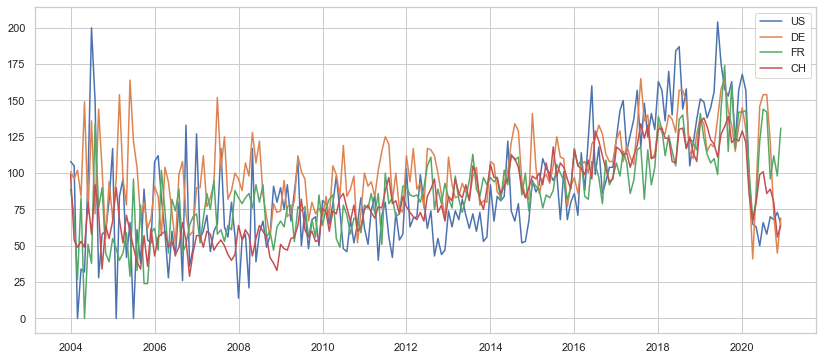

In [210]:


fig = plt.figure(figsize=(14,6))
plt.plot(US.index[-1000:], US[-1000:], label='US')
plt.plot(DE.index[-1000:], DE[-1000:], label='DE')
plt.plot(FR.index[-1000:], FR[-1000:], label='FR')
plt.plot(CH.index[-1000:], CH[-1000:], label='CH')
#plt.plot(dfs["JP"].index[-196:], dfs["JP"][kw_dict["JP"][a]][-196:], label='JP')

plt.legend()
plt.show()
#plt.plot(dfs["DE"]["swiss mountain"])

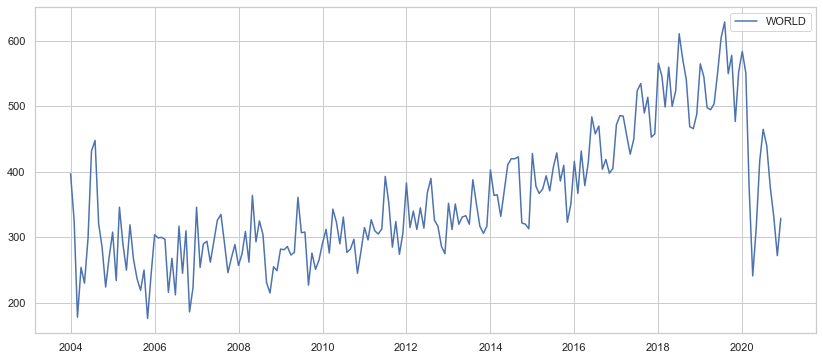

In [211]:
fig = plt.figure(figsize=(14,6))
plt.plot(WORLD.index[-1000:], WORLD[-1000:], label='WORLD')



plt.legend()
plt.show()

# II. Data Processing

In [212]:
# Loading the data (from Jan 2009 to December 2020)
tourism = pd.read_csv('data/Tourism.csv', delimiter=';', header=1)

In [213]:
tourism.head(5)

,Year,Month,Canton,Visitors' country of residence - total Arrivals,Switzerland Arrivals,Baltic States Arrivals,Germany Arrivals,France Arrivals,Italy Arrivals,Austria Arrivals,...,United Arab Emirates Arrivals,Serbia and Montenegro Arrivals,Croatia Arrivals,Romania Arrivals,Russia Arrivals,Slovakia Arrivals,Slovenia Arrivals,Czechia Arrivals,Ukraine Arrivals,Serbia Arrivals
0,2009,January,Switzerland,1064111,528523,1250,154530,44363,38939,10142,...,...,919,963,1955,21566,644,638,1885,2623,...
1,2009,February,Switzerland,1089483,521069,864,160914,59787,35721,10615,...,...,779,728,1657,9881,920,595,2435,1328,...
2,2009,March,Switzerland,1196859,567431,1290,187297,55015,43895,14476,...,...,964,965,2010,13485,1123,780,3676,1839,...
3,2009,April,Switzerland,1045137,468308,1671,164642,48102,38747,13328,...,...,916,1010,1750,9139,1491,1073,3029,1341,...
4,2009,May,Switzerland,1214666,548389,1120,183987,52869,40187,16379,...,...,919,903,1638,13502,1014,847,3823,1690,...


In [214]:
#Reindexing
tourism.index = pd.date_range('2009-01-01', '2020-12-01', freq= 'MS')

#Drop useless columns
tourism.drop(['Year', 'Month', 'Canton'], axis = 1, inplace = True)

#Replacing '...' values by 0 and Converting arrival string values into integer values
for column in tourism.columns:
    tourism[column] = tourism[column].apply(lambda x : 0 if x == '...' else float(x))
    
#Reformatting column names 
f = lambda x: x[: -(len(x.split()[-1])+1)]
tourism.columns =  [f(x) for x in tourism.columns]

In [215]:
# Selecting the corona period of every year 
corona_periods = pd.date_range(f'2009-01-01', periods=5 , freq = 'MS')
for i in range(2010, 2021):
    corona_periods = corona_periods.append(pd.date_range(f'{i}-01-01', periods= 5, freq = 'MS'))

corona_yearly_periods = tourism.loc[corona_periods]

In [216]:
corona_period_germany_2018 = corona_yearly_periods['Germany'].loc[pd.date_range(f'2018-01-01', periods= 5, freq = 'MS')]
corona_period_germany_2019 = corona_yearly_periods['Germany'].loc[pd.date_range(f'2019-01-01', periods= 5, freq = 'MS')]
corona_period_germany_2020 = corona_yearly_periods['Germany'].loc[pd.date_range(f'2020-01-01', periods= 5, freq = 'MS')]


In [217]:
tourism.head(3)

,Visitors' country of residence - total,Switzerland,Baltic States,Germany,France,Italy,Austria,United Kingdom,Irland,Netherlands,...,United Arab Emirates,Serbia and Montenegro,Croatia,Romania,Russia,Slovakia,Slovenia,Czechia,Ukraine,Serbia
2009-01-01,1064111.0,528523.0,1250.0,154530.0,44363.0,38939.0,10142.0,53636.0,2662.0,20687.0,...,0.0,919.0,963.0,1955.0,21566.0,644.0,638.0,1885.0,2623.0,0.0
2009-02-01,1089483.0,521069.0,864.0,160914.0,59787.0,35721.0,10615.0,65594.0,2880.0,39239.0,...,0.0,779.0,728.0,1657.0,9881.0,920.0,595.0,2435.0,1328.0,0.0
2009-03-01,1196859.0,567431.0,1290.0,187297.0,55015.0,43895.0,14476.0,61323.0,2744.0,24138.0,...,0.0,964.0,965.0,2010.0,13485.0,1123.0,780.0,3676.0,1839.0,0.0


In [219]:
#Taking the median per year for every country
total_arrivals_per_country =  tourism.groupby(tourism.index.map(lambda x : x.year)).median().T
total_arrivals_per_country_during_corona = corona_yearly_periods.groupby(corona_yearly_periods.index.map(lambda x : x.year)).median().T


In [220]:
total_arrivals_per_country.head(3)

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Visitors' country of residence - total,1205762.5,1269687.5,1270058.5,1303630.5,1326127.0,1376105.5,1367459.5,1403172.5,1463063.5,1542019.5,1569376.0,832943.5
Switzerland,557910.0,580441.5,588889.0,616644.5,615355.5,642263.5,636332.5,668932.5,685699.0,719934.5,736524.5,644719.0
Baltic States,1270.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [221]:
def remove_useless_select_year_and_sort(data, year, normalize = False):
    final = pd.DataFrame(data.drop(["Visitors' country of residence - total", 'Switzerland'], axis = 0)[year])\
                                    .sort_values(by= [year], ascending=False)\
                                    .reset_index().rename(columns={'index':'Country', year : 'Arrivals'}, inplace=False)
    return final

In [222]:
total_arrivals_per_country_2018 = remove_useless_select_year_and_sort(total_arrivals_per_country, 2018)
total_arrivals_per_country_during_corona_2018 = remove_useless_select_year_and_sort(total_arrivals_per_country_during_corona, 2018)
total_arrivals_per_country_2020 = remove_useless_select_year_and_sort(total_arrivals_per_country, 2020)
total_arrivals_per_country_during_corona_2020 = remove_useless_select_year_and_sort(total_arrivals_per_country_during_corona, 2020)


In [223]:
total_arrivals_per_country_2018

,Country,Arrivals
0,Germany,135259.5
1,China,82211.0
2,United States,70335.5
3,United Kingdom,58511.5
4,France,57899.5
...,...,...
71,Gulf States,0.0
72,"Australia, New Zealand, Oceania",0.0
73,Serbia and Montenegro,0.0
74,"Central America, Caribbean",0.0


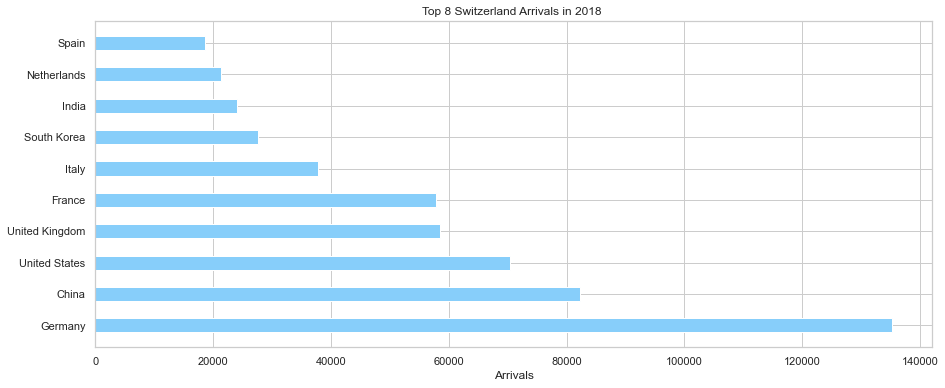

In [224]:
fig, ax = plt.subplots(figsize = (15, 6))

ind = np.arange(10)    # the x locations for the groups
width = 0.45       # the width of the bars


p1 = ax.barh(width/2 + ind, total_arrivals_per_country_2018['Arrivals'][:10], width, color = 'lightskyblue')#, yerr=err(median_sugar_switzerland))

ax.set_title('Top 8 Switzerland Arrivals in 2018 ')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(total_arrivals_per_country_2018['Country'][:10])

ax.autoscale_view()

plt.xlabel('Arrivals')
plt.savefig('images/Top_8_Arrivals_2018.png', transparent=True, bbox_inches='tight', dpi = 300)
plt.show()

<AxesSubplot:xlabel='Arrivals', ylabel='Country'>

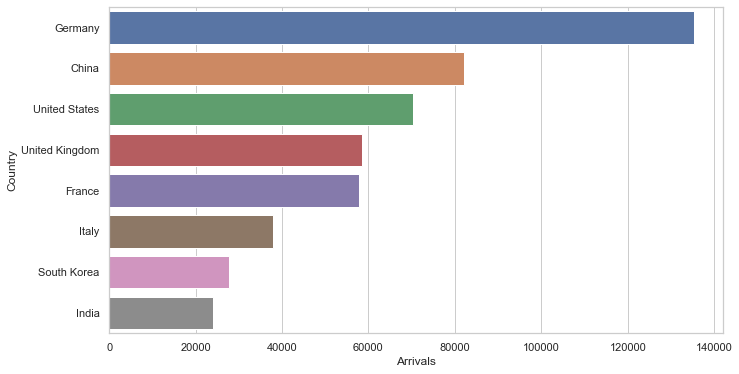

In [226]:
sns.set(rc={'figure.figsize':(11,6)})
sns.set(style='whitegrid')
sns.barplot(x='Arrivals' , y='Country', data = total_arrivals_per_country_2018[:8], orient='h')

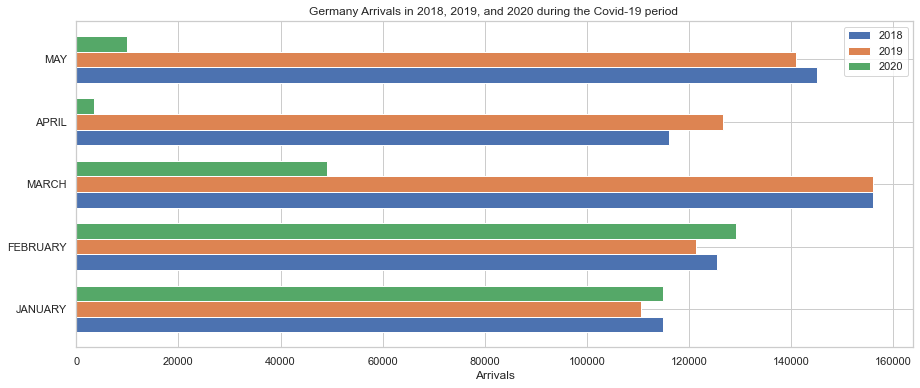

In [227]:
fig, ax = plt.subplots(figsize = (15, 6))

ind = np.arange(5)    # the x locations for the groups
width = 0.25       # the width of the bars


p1 = ax.barh(ind - width, corona_period_germany_2018[:5], width)
p2 = ax.barh(ind ,corona_period_germany_2019[:5], width)
p3 = ax.barh(ind + width,corona_period_germany_2020[:5], width)

ax.set_title('Germany Arrivals in 2018, 2019, and 2020 during the Covid-19 period ')
ax.set_yticks(ind)
ax.set_yticklabels(np.array(['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY']))


ax.legend((p1[0], p2[0], p3[0]), ('2018', '2019', '2020'))
ax.autoscale_view()

plt.xlabel('Arrivals')
plt.savefig('images/Germany_Arrivals_Covid_Period.png', transparent=True, bbox_inches='tight', dpi = 300)
plt.show()

In [228]:
# this file contains topologies for all countries in the world_map
world_map = './data/world-countries.json'
json_object = json.load(open(world_map))

## Ckeck arrivals to Switzerland by country in 2018

In [229]:
for feature in json_object['features']:
    country = feature['properties']['name']
    if country not in total_arrivals_per_country_2018.Country.values:
        df =  pd.DataFrame({'Country': country, 'Arrivals': 0}, index = np.arange(1))
        total_arrivals_per_country_2018 = pd.concat([total_arrivals_per_country_2018 ,df])


In [231]:
map = folium.Map(location=[20, 0], zoom_start=2)

map.choropleth(geo_data=world_map, data=total_arrivals_per_country_2018,
             columns=['Country', 'Arrivals'],
             key_on='feature.properties.name',
             fill_color='BuGn')

map

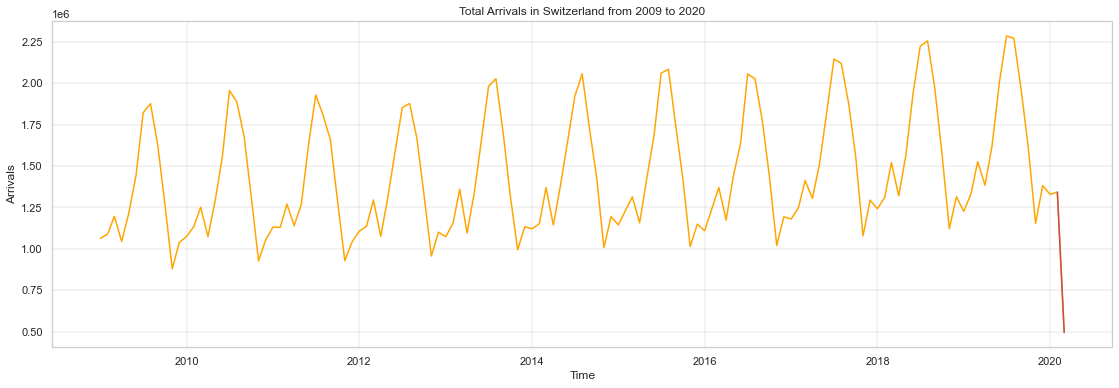

In [103]:
#Plot total number of Arrivals from Jan 2009 to March 2020 (Lockdown in Switzerland)
plt.figure(figsize= (19,6 ))
plt.plot(tourism[:datetime(2020,3,1)].index, data["Visitors' country of residence - total"][:datetime(2020,3,1)], color = 'orange')
plt.plot(data[datetime(2020,2,1):datetime(2020,3,1)].index, data["Visitors' country of residence - total"][datetime(2020,2,1):datetime(2020,3,1)], color = 'r')
plt.title('Total Arrivals in Switzerland from 2009 to 2020')
plt.xlabel('Time')
plt.ylabel('Arrivals')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

## AR Base Modelisation

In [104]:
#Covid crisis for our testSet
start_date_testing = datetime(2018,3,1)
end_date_testing = datetime(2020,10,1)

Arrivals = pd.DataFrame(data["Visitors' country of residence - total"])
Arrivals.rename(columns = {"Visitors' country of residence - total": 'Total Arrivals'}, inplace = True)

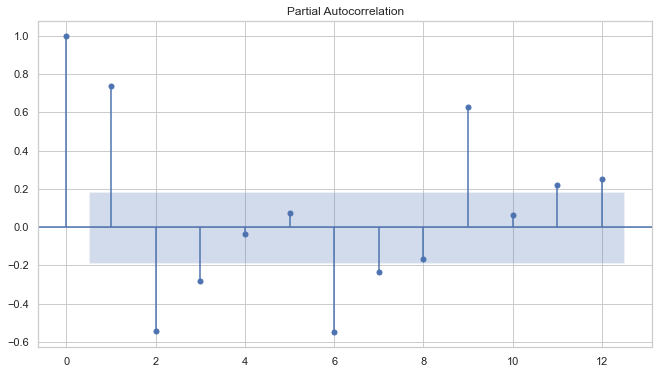

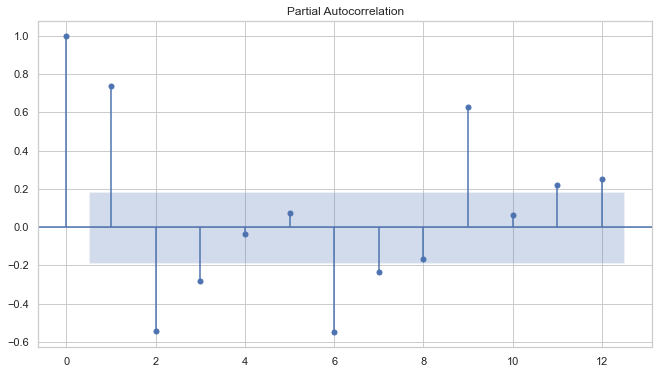

In [105]:
plot_pacf(Arrivals['Total Arrivals'][:start_date_testing], lags=12, method='ywm')

ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values: it describes how well the present value of the series is related with its past values.


PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. For example, if we are regressing a variable Y on other variables X1, X2, and X3, the partial correlation between Y and X3 is the amount of correlation between Y and X3 that is not explained by their common correlations with X1 and X2.

Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

We observe a significant partial correlation with variables in delays list below

In [106]:
pacf_coeff = pacf(Arrivals['Total Arrivals'][:start_date_testing], nlags=12, method='ywm')

delays = [1,2,3,6,7,8,9,12]
lags = dict(zip(delays, (pacf_coeff[i] for i in delays)))

for lag in lags.keys() :
    Arrivals['t-'+ str(lag)] = Arrivals['Total Arrivals'].shift(lag)

Arrivals.dropna(axis=0, inplace=True)

In [107]:
Arrivals.head(4)

,Total Arrivals,t-1,t-2,t-3,t-6,t-7,t-8,t-9,t-12
2010-01-01,1075731.0,1039895.0,880617.0,1267800.0,1821751.0,1446249.0,1214666.0,1045137.0,1064111.0
2010-02-01,1136889.0,1075731.0,1039895.0,880617.0,1876038.0,1821751.0,1446249.0,1214666.0,1089483.0
2010-03-01,1251923.0,1136889.0,1075731.0,1039895.0,1621888.0,1876038.0,1821751.0,1446249.0,1196859.0
2010-04-01,1074035.0,1251923.0,1136889.0,1075731.0,1267800.0,1621888.0,1876038.0,1821751.0,1045137.0


In [108]:
True_Arrivals = Arrivals['Total Arrivals'][start_date_testing : end_date_testing]

In [109]:
Hotels = pd.read_csv('data/Hotel.csv', header = 1, index_col= 'Mois', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Hotels = Hotels.rename(columns = {'Hotel: (Suisse)' : 'Switzerland_Hotels_Trend'})
Airbnb = pd.read_csv('data/Airbnb.csv', header = 1, index_col= 'Month', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Airbnb = Airbnb.rename(columns = {'airbnb: (France)' : 'France_Airbnb_Trend'})
Covid_19 = pd.read_csv('data/Covid19.csv', header = 1, index_col= 'Month', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Covid_19 = Covid_19.rename(columns = {'covid19: (Switzerland)' : 'Covid_19_France'})

In [110]:
Airbnb['France_Airbnb_Trend'] = Airbnb['France_Airbnb_Trend'].apply(lambda x : 0 if x == '<\xa01'else float(x))

In [111]:
Covid_19

,Covid_19_France
Month,
2009-01-01,0
2009-02-01,0
2009-03-01,0
2009-04-01,0
2009-05-01,0
...,...
2020-08-01,22
2020-09-01,19
2020-10-01,24


In [112]:
r = np.corrcoef(Arrivals['Total Arrivals'].values, Hotels.loc[Arrivals.index].values.reshape((1,-1))[0])

In [113]:
#Correlation Coeff between Hotels Trend and True Arrivals 
r[0][1]

0.7760672747360668

In [114]:
Arrivals = pd.merge(Arrivals, Hotels, right_index = True, left_index=True)
Arrivals = pd.merge(Arrivals, Airbnb, right_index = True, left_index=True)
Arrivals = pd.merge(Arrivals, Covid_19, right_index = True, left_index=True)


In [115]:
Arrivals

,Total Arrivals,t-1,t-2,t-3,t-6,t-7,t-8,t-9,t-12,Switzerland_Hotels_Trend,France_Airbnb_Trend,Covid_19_France
2010-01-01,1075731.0,1039895.0,880617.0,1267800.0,1821751.0,1446249.0,1214666.0,1045137.0,1064111.0,81,0.0,0
2010-02-01,1136889.0,1075731.0,1039895.0,880617.0,1876038.0,1821751.0,1446249.0,1214666.0,1089483.0,82,0.0,0
2010-03-01,1251923.0,1136889.0,1075731.0,1039895.0,1621888.0,1876038.0,1821751.0,1446249.0,1196859.0,83,0.0,0
2010-04-01,1074035.0,1251923.0,1136889.0,1075731.0,1267800.0,1621888.0,1876038.0,1821751.0,1045137.0,80,0.0,0
2010-05-01,1287452.0,1074035.0,1251923.0,1136889.0,880617.0,1267800.0,1621888.0,1876038.0,1214666.0,84,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,1525425.0,1539928.0,716421.0,307372.0,1342777.0,1328894.0,1381913.0,1154630.0,2270490.0,76,82.0,22
2020-09-01,1291992.0,1525425.0,1539928.0,716421.0,496239.0,1342777.0,1328894.0,1381913.0,1958831.0,72,46.0,19
2020-10-01,949466.0,1291992.0,1525425.0,1539928.0,51479.0,496239.0,1342777.0,1328894.0,1612160.0,52,37.0,24
2020-11-01,0.0,949466.0,1291992.0,1525425.0,307372.0,51479.0,496239.0,1342777.0,1154630.0,33,20.0,19


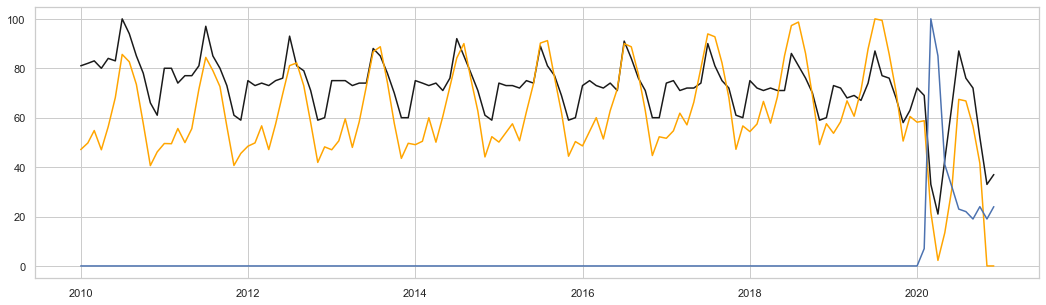

In [116]:
#Hotel plot
fig,axes = plt.subplots(figsize=(18,5))
axes.plot((Arrivals['Switzerland_Hotels_Trend']*100)/max(Arrivals['Switzerland_Hotels_Trend']), label = 'Actual',color = 'k')
axes.plot((Arrivals['Total Arrivals']*100)/max(Arrivals['Total Arrivals']), label = 'Actual',color = 'orange')
axes.plot((Arrivals['Covid_19_France']*100)/max(Arrivals['Covid_19_France']), label = 'Actual')

In [117]:
#Implementation of the Linear Regression model with or without the Google Trends features, with a training window increasing at every iteration

def Auto_Regressive_Model(True_Labels, end_date_testing, dataset, lags, trends, with_trends=False):
    
    Arrivals_Predictions = True_Labels.copy()

    if (with_trends):
        lags.extend(trends)
        
    for train_last in True_Arrivals.index:
        train = dataset[ :train_last -timedelta(days=1)]
        test = dataset[train_last : end_date_testing]
        
        X_train = train[lags].values
        X_test = test[lags].values
        
            
        y_train = train['Total Arrivals'].values
        y_test = test['Total Arrivals'].values
        
    
        lr = LinearRegression()
    
        lr.fit(X_train, y_train)
        
            
        if(train_last==start_date_testing):
            print('The intercept value is:', lr.intercept_ )
            for i, lag in enumerate(lags):
                print('The final estimation of {} is: {}'.format(lag, lr.coef_[i]))
        
        pred = lr.predict(X_test)
    
        Arrivals_Predictions[train_last] = pred[0]
        
    MAE = mean_absolute_error(True_Labels, Arrivals_Predictions)
    print("MAE :{}".format(MAE) )
    
    return Arrivals_Predictions, MAE

In [118]:
lags_1 = ['t-1', 't-9']
lags_2 = ['t-1']
lags_3 = ['t-1', 't-2', 't-6', 't-9', 't-12']

trends = [ "Switzerland_Hotels_Trend", "Covid_19_France"]

In [128]:
Baseline_Arrivals_Predictions_1, Baseline_MAE_1= Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_1.copy(),\
                                                                    trends.copy(), with_trends = False)




The intercept value is: -57408.38279918744
The final estimation of t-1 is: 0.8326629747877003
The final estimation of t-9 is: 0.21296211766062637
MAE :254356.9270592925


In [129]:
Baseline_Arrivals_Predictions_2, Baseline_MAE_2 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_2.copy(),\
                                                                    trends.copy(), with_trends = False)


The intercept value is: 369342.57569594914
The final estimation of t-1 is: 0.7405778398452696
MAE :259601.02601321967


In [130]:
Baseline_Arrivals_Predictions_3, Baseline_MAE_3 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                    lags_3.copy(),\
                                                    trends.copy(), with_trends = False)


The intercept value is: -110488.7240846816
The final estimation of t-1 is: 0.033942903596706236
The final estimation of t-2 is: 0.017382718263641295
The final estimation of t-6 is: 0.016791367771042363
The final estimation of t-9 is: 0.04152614450236643
The final estimation of t-12 is: 0.991510599936526
MAE :201801.5962619076


In [131]:
Trends_Arrivals_Predictions_1, Trend_MAE_1 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_1.copy(),\
                                                                    trends.copy(), with_trends = True)




The intercept value is: -914818.5005731718
The final estimation of t-1 is: 0.6078655342894421
The final estimation of t-9 is: 0.14544539329238887
The final estimation of Switzerland_Hotels_Trend is: 16930.45047628458
The final estimation of Covid_19_France is: 0.0
MAE :183985.64045771828


In [132]:
Trends_Arrivals_Predictions_2, Trend_MAE_2 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_2.copy(),\
                                                                    trends.copy(), with_trends = True)




The intercept value is: -667726.1988949785
The final estimation of t-1 is: 0.5362334071804862
The final estimation of Switzerland_Hotels_Trend is: 17687.05679704621
The final estimation of Covid_19_France is: 0.0
MAE :207542.96324480322


In [133]:
Trends_Arrivals_Predictions_3, Trend_MAE_3 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_3.copy(),\
                                                                    trends.copy(), with_trends = True)




The intercept value is: -221827.4600366198
The final estimation of t-1 is: 0.012047894149833803
The final estimation of t-2 is: 0.047695172934795645
The final estimation of t-6 is: 0.024675201114596937
The final estimation of t-9 is: 0.04817428387810201
The final estimation of t-12 is: 0.9788070044954961
The final estimation of Switzerland_Hotels_Trend is: 1290.0857104825877
The final estimation of Covid_19_France is: 0.0
MAE :115113.79812288881


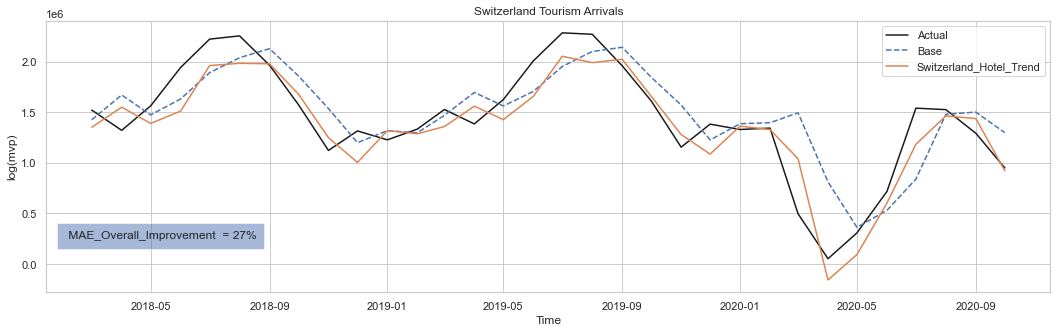

In [137]:
# I plot the result of the increasing size rolling window: It is the exact same graph obtained in the paper
fig,axes = plt.subplots(figsize=(18,5))

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions_1, linestyle='dashed', label='Base')
axes.plot(Trends_Arrivals_Predictions_1, label='Switzerland_Hotel_Trend')


plt.text('2018-02-01', 0.25*1e6, ' MAE_Overall_Improvement  = {}%'.format( int(100 * np.abs(Trend_MAE_1-Baseline_MAE_1)/Baseline_MAE_1)), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('log(mvp)')
plt.title('Switzerland Tourism Arrivals')
plt.legend()

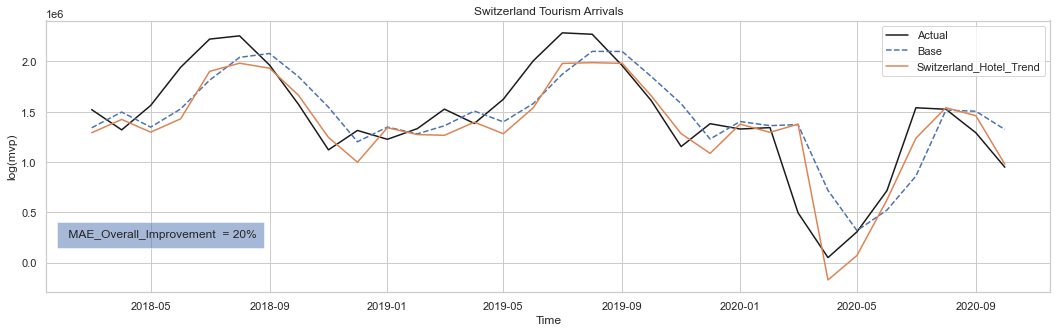

In [135]:
# I plot the result of the increasing size rolling window: It is the exact same graph obtained in the paper
fig,axes = plt.subplots(figsize=(18,5))

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions_2, linestyle='dashed', label='Base')
axes.plot(Trends_Arrivals_Predictions_2, label='Switzerland_Hotel_Trend')


plt.text('2018-02-01', 0.25*1e6, ' MAE_Overall_Improvement  = {}%'.format(int(100 * np.abs(Trend_MAE_2-Baseline_MAE_2)/Baseline_MAE_2)), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('log(mvp)')
plt.title('Switzerland Tourism Arrivals')
plt.legend()

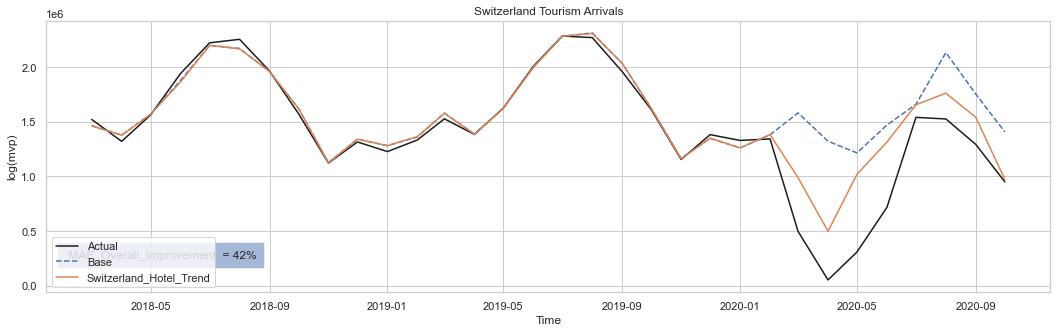

In [136]:
# I plot the result of the increasing size rolling window: It is the exact same graph obtained in the paper
fig,axes = plt.subplots(figsize=(18,5))

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions_3, linestyle='dashed', label='Base')
axes.plot(Trends_Arrivals_Predictions_3, label='Switzerland_Hotel_Trend')


plt.text('2018-02-01', 0.25*1e6, ' MAE_Overall_Improvement  = {}%'.format(int(100 * np.abs(Trend_MAE_3-Baseline_MAE_3)/Baseline_MAE_3)), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('log(mvp)')
plt.title('Switzerland Tourism Arrivals')
plt.legend()

# Choosing Trends Keywords

## Parsing text from website to find related topics 

## Proposing other Trends keywords

Some keywords can be expected to serve as indicators of hotel booking. For example 'Hotel Switzerland' or 'flight to switzerland'. All holidays-related words might not give a good correlation since poeple probably kept on searching for holiday destinations during the corona crisis. We will thus focus our effort to keywords implying holiday's logistic. People will book an hotel only when they are sure of travelling.

I will here propose a list of keywords that might be related to hotel reservations somehow. We will then test the correlation to find the best keywords to use in our model. For the sake of simplicity, we will try to limit ourselves to 5 keywords.

Suggested keywords : 'Holidays Switerland', 'Hotel Switzerland', 'Flight Switzerland', 'travel visa Switzerland', 'Geneva Airport', 'Zurich Airport', 'Visit Switzerland', 'Hike Switzerland', 'Visit Geneva', 'Visit Lucerne', 'Visit Zurich', 'Visit Lausanne', 'Ski in Switzerland', 'Skipass Zermatt', 'Airbnb Switzerland'

In addition to keywords, the categorising feature of Google Trends is going to be used for the categories 'Travel/Hotel&Accomodation', 'Travel/Touristic Destination/Ski Resort' and 'Travel/Touristic Destination/Switzerland'

We can also add keywords related to the COVID-19 crisis such as : 'Quarantine Switzerland', 'COVID 19 switzerland', 'covid restrictions Switzerland', 'travel restrictions switzerland', 'covid-19', 'Test covid switzerland'

The COVID-related words must be categorised differently than Hotel-related words. Indeed, those could not have been predicted before the emmergence of the COVID crisi and thus it would not have made sense to build a model using them one year ago. However, since we know about the crisis, we can use them in order to predict the future of the crisis. After all, the goal of this model is to predict the present, thus we allow ourselves to use those present informations to improve the model. We will use both features and they will be reffered to as 'Hotel-Trends' and 'Hotel+COVID-Trends'.

In [138]:
# Recuperer les trends

def import_trends(trends_list):
    df = {}
    #print(trends_list)
    
    lc="en-US"
    pytrends = TrendReq(hl=lc, tz=360)
    pytrends.build_payload(trends_list, cat=0, timeframe='all', gprop='')
    #print(pytrends.interest_over_time())
    df = pytrends.interest_over_time()  
    df = df.drop(columns='isPartial')
    #print( df[trend])
    return df


In [139]:
def import_and_merges(trends_list,to_be_merge_to):
    trends_content = import_trends(trends_list)    
    to_be_merge_to = pd.merge(to_be_merge_to, trends_content, right_index = True, left_index=True)      
    return to_be_merge_to

### Importing suggested trends 

In [140]:
suggested_trends = ['Holidays Switerland', 'Hotel Switzerland', 'Flight Switzerland', 'travel visa Switzerland', 'Geneva Airport', 'Zurich Airport', 'Visit Switzerland', 'Hike Switzerland', 'Visit Geneva', 'Visit Lucerne', 'Visit Zurich', 'Visit Lausanne', 'Ski in Switzerland', 'Skipass Zermatt', 'Airbnb Switzerland']
suggested_trends1 = suggested_trends[0:3]
suggested_trends2 = suggested_trends[4:7]
suggested_trends3 = suggested_trends[8:11]
suggested_trends4 = suggested_trends[12:15]

covid_trends = ['Quarantine Switzerland', 'COVID 19 switzerland', 'covid restrictions Switzerland', 'travel restrictions switzerland', 'covid-19', 'Test covid switzerland']
covid_trends1 = covid_trends[0:3]
covid_trends2 = covid_trends[4:7]

In [141]:
Arrivals_lags_features = Arrivals
Arrivals_lags_features = import_and_merges(suggested_trends1,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(suggested_trends2,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(suggested_trends3,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(suggested_trends4,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(covid_trends1,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(covid_trends2,Arrivals_lags_features)

### Importing trends from topic-analysis
We select the top 10 words from topic analysis of webscraping (without the three first ones).

In [142]:
topics_trends = ["swiss " + word for word in list(word_count_df.index[3:13])]
topics_trends

['swiss travel',
 'swiss hotel',
 'swiss one',
 'swiss visit',
 'swiss best',
 'swiss lake',
 'swiss price',
 'swiss view',
 'swiss get',
 'swiss mountain']

In [143]:
topics_trends1 = topics_trends[0:3]
topics_trends2 = topics_trends[4:7]
topics_trends3 = topics_trends[8:10]
Arrivals_lags_features = import_and_merges(topics_trends1,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(topics_trends2,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(topics_trends3,Arrivals_lags_features)

### Importing category trends

We include trends from the category feature of google trends


In [144]:
category_trends = ['Travel_HotelAccomodation', 'Travel_TouristicDestination_SkiResort' , 'Travel_TouristicDestination_Switzerland']

#reading csv's
Travel_HotelAccomodation = pd.read_csv('Data/Trends/Travel_HotelAccomodation.csv', header = 1, index_col= 'Mois', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Travel_TouristicDestination_SkiResort = pd.read_csv('Data/Trends/Travel_TouristicDestination_SkiResort.csv', header = 1, index_col= 'Mois', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Travel_TouristicDestination_Switzerland = pd.read_csv('Data/Trends/Travel_TouristicDestination_Switzerland.csv', header = 1, index_col= 'Mois', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))

#renaming the columns
Travel_HotelAccomodation = Travel_HotelAccomodation.rename(columns = {'Geo: Suisse' : 'Travel_HotelAccomodation'})
Travel_TouristicDestination_SkiResort = Travel_TouristicDestination_SkiResort.rename(columns = {'Geo: Suisse' : 'Travel_TouristicDestination_SkiResort'})
Travel_TouristicDestination_Switzerland = Travel_TouristicDestination_Switzerland.rename(columns = {'Geo: Suisse' : 'Travel_TouristicDestination_Switzerland'})

#merging with the main df
Arrivals_lags_features = pd.merge(Arrivals_lags_features, Travel_HotelAccomodation, right_index = True, left_index=True)
Arrivals_lags_features = pd.merge(Arrivals_lags_features, Travel_TouristicDestination_SkiResort, right_index = True, left_index=True)
Arrivals_lags_features = pd.merge(Arrivals_lags_features, Travel_TouristicDestination_Switzerland, right_index = True, left_index=True)

#does it work ?
Arrivals_lags_features

,Total Arrivals,t-1,t-2,t-3,t-6,t-7,t-8,t-9,t-12,Switzerland_Hotels_Trend,...,swiss hotel,swiss one,swiss best,swiss lake,swiss price,swiss get,swiss mountain,Travel_HotelAccomodation,Travel_TouristicDestination_SkiResort,Travel_TouristicDestination_Switzerland
2010-01-01,1075731.0,1039895.0,880617.0,1267800.0,1821751.0,1446249.0,1214666.0,1045137.0,1064111.0,81,...,58,6,74,9,33,10,39,35,55,48
2010-02-01,1136889.0,1075731.0,1039895.0,880617.0,1876038.0,1821751.0,1446249.0,1214666.0,1089483.0,82,...,60,7,96,16,39,10,37,36,49,46
2010-03-01,1251923.0,1136889.0,1075731.0,1039895.0,1621888.0,1876038.0,1821751.0,1446249.0,1196859.0,83,...,58,5,83,12,33,12,35,39,39,44
2010-04-01,1074035.0,1251923.0,1136889.0,1075731.0,1267800.0,1621888.0,1876038.0,1821751.0,1045137.0,80,...,55,8,79,9,29,8,42,36,33,42
2010-05-01,1287452.0,1074035.0,1251923.0,1136889.0,880617.0,1267800.0,1621888.0,1876038.0,1214666.0,84,...,58,8,66,17,39,8,32,37,33,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,1525425.0,1539928.0,716421.0,307372.0,1342777.0,1328894.0,1381913.0,1154630.0,2270490.0,76,...,25,6,81,10,67,13,26,26,54,55
2020-09-01,1291992.0,1525425.0,1539928.0,716421.0,496239.0,1342777.0,1328894.0,1381913.0,1958831.0,72,...,22,7,64,8,63,10,26,23,48,48
2020-10-01,949466.0,1291992.0,1525425.0,1539928.0,51479.0,496239.0,1342777.0,1328894.0,1612160.0,52,...,21,7,70,17,68,8,21,19,45,43
2020-11-01,0.0,949466.0,1291992.0,1525425.0,307372.0,51479.0,496239.0,1342777.0,1154630.0,33,...,20,6,79,12,65,8,28,14,37,35


### We redefine our regression function a bit differently to include p-values

In [152]:
#Implementation of the Linear Regression model with or without the Google Trends features, with a training window increasing at every iteration


def Auto_Regressive_Model(True_Labels, end_date_testing, dataset, lags, trends, with_trends=False):
    
    Arrivals_Predictions = True_Labels.copy()

    if (with_trends):
        lags.extend(trends)
        
    for train_last in True_Arrivals.index:
        train = dataset[ :train_last -timedelta(days=1)]
        test = dataset[train_last : end_date_testing]
        
        X_train = train[lags].values
        X_test = test[lags].values
        
        y_train = train['Total Arrivals'].values
        y_test = test['Total Arrivals'].values
    
        lm = LinearRegression()
        lm.fit(X_train,y_train)
       
        predictions = lm.predict(X_test)    
        Arrivals_Predictions[train_last] = predictions[0]
    
        if(train_last==start_date_testing):
            X = X_train
            y = y_train

            X2 = sm.add_constant(X)
            est = sm.OLS(y, X2)
            est2 = est.fit()
            #print(est2.summary())
            pvals = est2.pvalues
            coeff = est2.params
            features = np.append('intercept',lags)
            
            feature_eval = pd.DataFrame({"features":features,
                                  "coefficient":coeff,
                                  "p value":pvals, 
                                })
    
           

      
  
    MAE = mean_absolute_error(True_Labels, Arrivals_Predictions)
    print("MAE :{}".format(MAE))
        
    return Arrivals_Predictions, MAE, feature_eval

In [153]:
#pour pas supp
intercept, coef = lm.intercept_,lm.coef_
params = np.append(intercept,coef)

newX = pd.DataFrame({"Constant":np.ones(len(X_train))}).join(pd.DataFrame(X_train))
MSE = (sum((y_test-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b]
                
sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

features = np.append('intercept',lags)
        
myDF3 = pd.DataFrame()
myDF3["feature"],myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [features,params,sd_b,ts_b,p_values]
print(myDF3)
        

NameError: name 'lm' is not defined

### testing the models

In [174]:
trends = category_trends
lags = ['t-1','t-9']

Arrival_prediction_Hotel_test, MAE_Arrival_prediction_Hotel_test, table = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals_lags_features,\
                                                                    lags.copy(),\
                                                                    trends.copy(), with_trends = True)

table

MAE :221535.02073013646


,features,coefficient,p value
0,intercept,-309352.294067,3.256735e-01
1,t-1,0.487242,4.546250e-05
2,t-9,-0.032134,7.667164e-01
3,Travel_HotelAccomodation,-33795.608686,1.343831e-05
4,Travel_TouristicDestination_SkiResort,-14698.998732,2.234621e-02
5,Travel_TouristicDestination_Switzerland,61699.088895,3.464331e-08


In [175]:
def chooses_best_features(sum_up_table, top_how_many, lags):
       
    sum_up_table=sum_up_table[1+len(lags):]
    print(sum_up_table)
    sum_up_table.sort_values(by=['p value'])
    best_features = sum_up_table[0:top_how_many]['features']
    
    return best_features

In [176]:
best = chooses_best_features(table,2,lags)
best

                                  features   coefficient       p value
3                 Travel_HotelAccomodation -33795.608686  1.343831e-05
4    Travel_TouristicDestination_SkiResort -14698.998732  2.234621e-02
5  Travel_TouristicDestination_Switzerland  61699.088895  3.464331e-08


3                 Travel_HotelAccomodation
4    Travel_TouristicDestination_SkiResort
Name: features, dtype: object

In [177]:
Arrival_prediction_Hotel_test, MAE_Arrival_prediction_Hotel_test, table = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals_lags_features,\
                                                                    lags.copy(),\
                                                                    best.copy(), with_trends = True)
Arrival_prediction_Hotel_test

MAE :228678.66718337816


2018-03-01    1.537320e+06
2018-04-01    1.768289e+06
2018-05-01    1.487985e+06
2018-06-01    1.659838e+06
2018-07-01    2.069267e+06
2018-08-01    2.212432e+06
2018-09-01    2.225583e+06
2018-10-01    1.858860e+06
2018-11-01    1.423974e+06
2018-12-01    1.238470e+06
2019-01-01    1.544174e+06
2019-02-01    1.471810e+06
2019-03-01    1.575635e+06
2019-04-01    1.780061e+06
2019-05-01    1.599782e+06
2019-06-01    1.788437e+06
2019-07-01    2.084577e+06
2019-08-01    2.267291e+06
2019-09-01    2.224097e+06
2019-10-01    1.817846e+06
2019-11-01    1.481252e+06
2019-12-01    1.242201e+06
2020-01-01    1.473641e+06
2020-02-01    1.530589e+06
2020-03-01    1.366382e+06
2020-04-01    4.143929e+05
2020-05-01    1.335272e+05
2020-06-01    4.436295e+05
2020-07-01    9.903596e+05
2020-08-01    1.583389e+06
2020-09-01    1.519577e+06
2020-10-01    1.193684e+06
Freq: MS, Name: Total Arrivals, dtype: float64

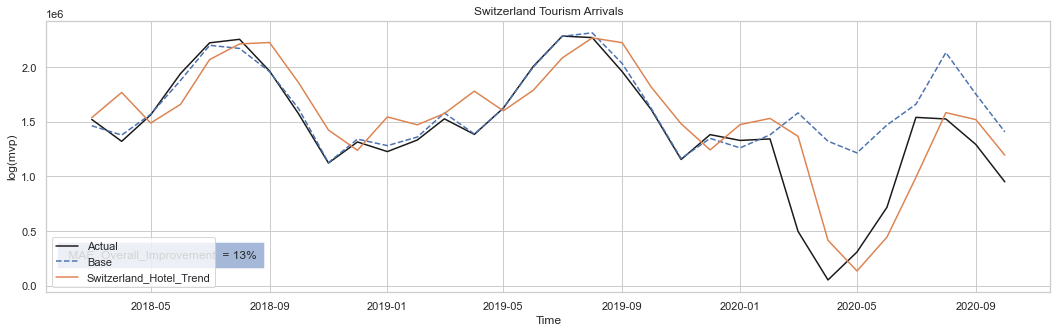

In [178]:
fig,axes = plt.subplots(figsize=(18,5))

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions_3, linestyle='dashed', label='Base')
axes.plot(Arrival_prediction_Hotel_test, label='Switzerland_Hotel_Trend')


plt.text('2018-02-01', 0.25*1e6, ' MAE_Overall_Improvement  = {}%'.format(int(100 * np.abs(MAE_Arrival_prediction_Hotel_test-Baseline_MAE_3)/Baseline_MAE_3)), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('log(mvp)')
plt.title('Switzerland Tourism Arrivals')
plt.legend()


